### create a random tensor

In [1]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
import caiman as cm
import matplotlib.pyplot as plt
%matplotlib inline
# xDim = 10
# yDim = 10
# tDim = 1000
# imgD_ = np.random.randn(xDim, yDim, tDim)

Using mxnet backend.
/Users/dalin/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Test if image stack is white

In [2]:
# max_spatial_corr = np.abs(cm.local_correlations(imgD_)).max()
# temp_corr = np.zeros((xDim, yDim))
# for nX in range(xDim):
#     for nY in range(yDim):
#         tD_ = imgD_[nX, nY, :]
#         tt = np.correlate(tD_, tD_, 'same')
#         max_tt = np.argmax(tt)
#         temp_corr[nX, nY] = tt[max_tt+1:max_tt+20].mean()/len(tD_)

# max_temp_corr = np.abs(temp_corr).max()

In [3]:
# # print the range of correlation level is accepted as white noise
# print('Maximum spatial correlation for white noise is :%f'%(max_spatial_corr))
# print('Maximum temporal correlation for white noise is :%f'%(max_temp_corr))

### Build up statistics for any image stacks

In [4]:
def computeCorrMax(imgD_):
    xDim, yDim, tDim =  imgD_.shape
    max_spatial_corr = np.abs(cm.local_correlations(imgD_)).max()
    temp_corr = np.zeros((xDim, yDim))
    for nX in range(xDim):
        for nY in range(yDim):
            tD_ = imgD_[nX, nY, :]
            tD_ = (tD_ - tD_.mean())/tD_.std()
            tt = np.correlate(tD_, tD_, 'same')
            max_tt = np.argmax(tt)
            temp_corr[nX, nY] = tt[max_tt+1:max_tt+20].mean()/len(tD_)
    max_temp_corr = np.abs(temp_corr).max()
    return max_spatial_corr, max_temp_corr

def computeCorrPrc(imgD_, perc= 90):
    xDim, yDim, tDim =  imgD_.shape
    max_spatial_corr = np.percentile(np.abs(cm.local_correlations(imgD_)), perc)
    temp_corr = np.zeros((xDim, yDim))
    for nX in range(xDim):
        for nY in range(yDim):
            tD_ = imgD_[nX, nY, :]
            tD_ = (tD_ - tD_.mean())/tD_.std()
            tt = np.correlate(tD_, tD_, 'same')
            max_tt = np.argmax(tt)
            temp_corr[nX, nY] = tt[max_tt+1:max_tt+20].mean()/len(tD_)
    max_temp_corr = np.percentile(np.abs(temp_corr), perc)
    return max_spatial_corr, max_temp_corr

def statWhiteness(imgD_, perc= 90):
    xDim, yDim, tDim =  imgD_.shape
    max_spatial_corr, max_temp_corr = computeCorrPrc(imgD_, perc)
    randImgD_ = np.random.randn(xDim, yDim, tDim)
    bound_spatial_corr, bound_temp_corr = computeCorrMax(randImgD_)
    return bound_spatial_corr >= max_spatial_corr, bound_temp_corr >= max_temp_corr
    

### Test tensor decomposition

In [5]:
cropRaw = np.load('Y_detr.npy')
t_cropRaw = tl.tensor(cropRaw)

In [6]:
cp_rank = 95

In [7]:
%%time
factors = parafac(t_cropRaw, rank=cp_rank, init='random', tol=10e-6)

CPU times: user 1min 43s, sys: 31.6 s, total: 2min 15s
Wall time: 1min 39s


In [8]:
cp_reconstruction = tl.kruskal_to_tensor(factors)

In [9]:
cropSDN = tl.to_numpy(cp_reconstruction)

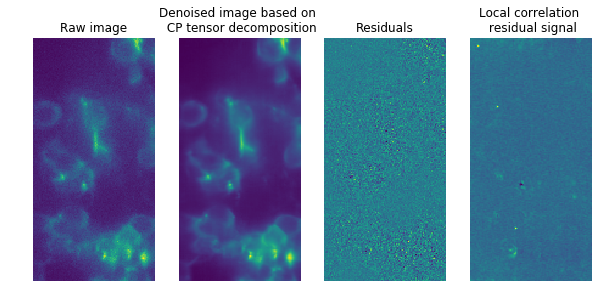

In [10]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 40))
ax1.imshow(cropRaw[:, :, 0])
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(cropSDN[:, :, 0])
ax2.set_title('Denoised image based on \n CP tensor decomposition')
ax2.axis('off')
ax3.imshow(cropRaw[:, :, 0] - cropSDN[:, :, 0])
ax3.set_title('Residuals')
ax3.axis('off')
ax4.imshow(cm.local_correlations(cropRaw - cropSDN))
ax4.set_title('Local correlation \n residual signal')
ax4.axis('off')
plt.savefig('Tensor_denoise_F.png', dpi=700, bbox_inches="tight")
plt.show()

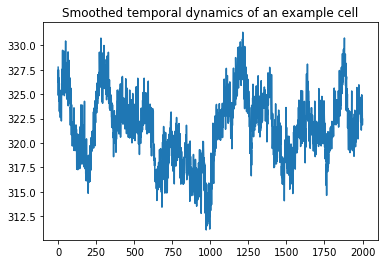

In [11]:
plt.plot(cropSDN[0:25, 60:90, :].mean(axis=0).mean(axis=0))
plt.title('Smoothed temporal dynamics of an example cell')
plt.show()

In [13]:
from scipy.io import savemat

savemat('cropSDN.mat', {'cropSDN': cropSDN[0:25, 60:90, :].mean(axis=0).mean(axis=0)})

In [ ]:
plt.plot(cropRaw[0:25, 60:90, :].mean(axis=0).mean(axis=0)-cropSDN[0:25, 60:90, :].mean(axis=0).mean(axis=0))
plt.title('Residual temporal dynamics of an example cell')
plt.show()

In [ ]:
spatialH, temporalH = statWhiteness(cropSDN-cropRaw, perc=95)
print('If the spatial residual signal is white? %s'%(spatialH))
print('If the temporal residual signal is white? %s'%(temporalH))